# Introduction

The goal of this work is to predict the vegetation index behavior of soybean areas located in south america region.

For this work, we used 50k soybean samples collected from thematic maps produced by the [Global Land Analysis & Discovery group](https://glad.umd.edu/) (GLAD) and vegetation index time series obtained from the [MOD13Q1](https://lpdaac.usgs.gov/products/mod13q1v006/) product of the [Moderate-Resolution Imaging Spectroradiometer](https://modis.gsfc.nasa.gov/about/).

# Imports

In [1]:
import os
import joblib
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

# Settings

In [2]:
INPUT_POINTS = '../input/soybean_2019_2020_samples.gpkg'
INPUT_DATA = '../input/soybean_southamerica_mod13q1_evi_2000_2019.csv'

FIELD_ID = 'fid'
FIELD_TIMESTAMP = 'timestamp'


TRAIN_FEATURES = ['evi']
TRAIN_VALUES = 500

PREDICT_FEATURE = 'evi'
PREDICT_START_DATE = '2019-01-01'
PREDICT_END_DATE = '2019-12-31'
PREDICT_VALUES = 23

SCALER_PATH = '/kaggle/working/lstm_scaler.save'
MODEL_PATH = '/kaggle/working/lstm_trained_model.h5'

# Load soybean samples

In [3]:
gdf = gpd.read_file(INPUT_POINTS)

# Plot all 50k soybean points

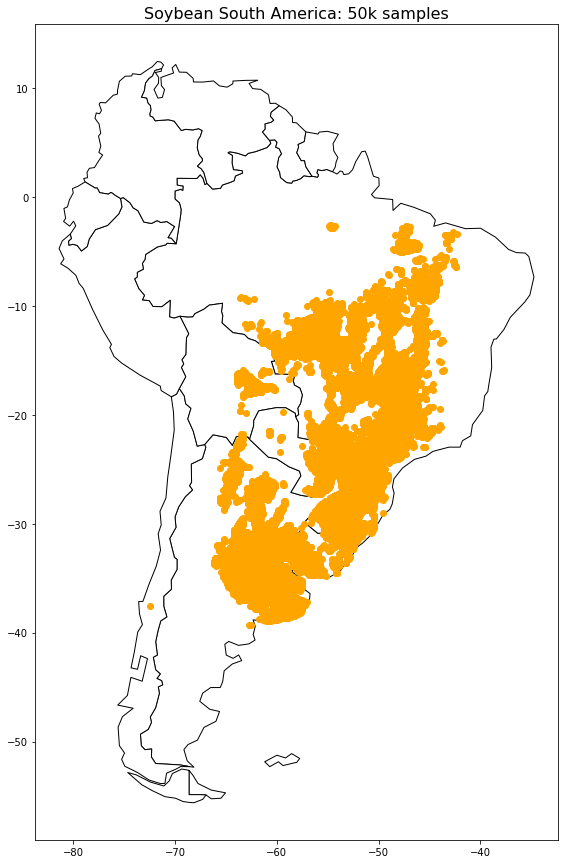

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world[world.continent == 'South America'].plot(color='white', edgecolor='black', figsize=(20, 15))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='orange')
plt.title('Soybean South America: 50k samples', fontsize=16)
plt.show()

# Load time series

In [5]:
df = pd.read_csv(INPUT_DATA)
df.tail()

fid        date      timestamp     evi
22849995  396631  2019-12-19  1576713600000  0.8397
22849996  396660  2019-12-19  1576713600000  0.3703
22849997  396670  2019-12-19  1576713600000  0.1588
22849998  396674  2019-12-19  1576713600000  0.7017
22849999  396685  2019-12-19  1576713600000  0.3602

# All time series ids

In [6]:
all_series = df[FIELD_ID].dropna().unique()
len(all_series)

50000

# Split time series in train and test

In [7]:
trainining_ids, test_ids = train_test_split(all_series, test_size=0.10, random_state=101)
len(trainining_ids), len(test_ids)

(45000, 5000)

# Load training dataset

In [8]:
def load_dataset(ids, dataset, train_values=500, predict_values=23):
    x = []
    y = []

    for id in tqdm.tqdm(ids):
        data = dataset[(dataset[FIELD_ID] == id)]
        index = pd.DatetimeIndex(pd.to_datetime(data[FIELD_TIMESTAMP],  unit='ms'))
        data.index = index

        x_data = data.loc[:PREDICT_START_DATE][TRAIN_FEATURES].dropna()
        y_data = data.loc[PREDICT_START_DATE:PREDICT_END_DATE][PREDICT_FEATURE].dropna()

        if len(y_data) != predict_values:
            continue

        x_data = tf.keras.preprocessing.sequence.pad_sequences([x_data], maxlen=train_values, dtype='float32')[0]

        x.append(x_data)
        y.append(y_data.values)

    return np.array(x), np.array(y)

train_x_data, train_y_data  = load_dataset(ids=trainining_ids, 
                             dataset=df, 
                             train_values=TRAIN_VALUES, 
                             predict_values=PREDICT_VALUES)

train_x_data.shape, train_y_data.shape

100%|██████████| 45000/45000 [29:06<00:00, 25.77it/s] 


((44960, 500, 1), (44960, 23))

# LSTM Model

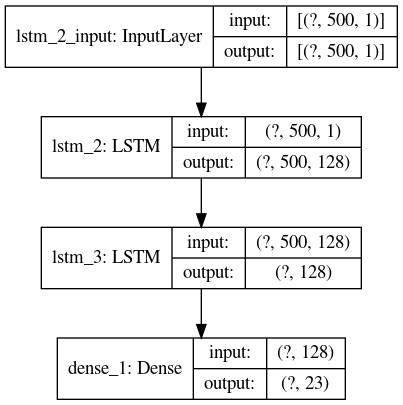

In [10]:
lstm_model = Sequential()

input_shape = (train_x_data.shape[1], 1)

lstm_model.add(LSTM(128, return_sequences=True, input_shape=input_shape))

lstm_model.add(LSTM(128))

lstm_model.add(Dense(train_y_data.shape[1]))

lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

tf.keras.utils.plot_model(lstm_model, show_shapes=True, to_file='/kaggle/working/model.png')

# Normalize data

In [11]:
if os.path.exists(SCALER_PATH):
    print("Loading saved scaler...")
    scaler = joblib.load(SCALER_PATH) 
else: 
    scaler = MinMaxScaler()
    scaler.fit(train_x_data.reshape(-1, train_x_data.shape[-1]))
    joblib.dump(scaler, SCALER_PATH)

In [12]:
for i, value in enumerate(train_x_data):
    value = value[~np.isnan(value).any(axis=1)]
    train_x_data[i] = scaler.transform(value)

for i, value in enumerate(train_y_data):
    value = value[~np.isnan(value).any()]
    train_y_data[i] = scaler.transform(value)

# Train model

Epoch 1/100
1054/1054 [==============================] - 55s 52ms/step - loss: 0.0170 - mean_absolute_error: 0.0986 - val_loss: 0.0122 - val_mean_absolute_error: 0.0815
Epoch 2/100
1054/1054 [==============================] - 54s 52ms/step - loss: 0.0120 - mean_absolute_error: 0.0809 - val_loss: 0.0114 - val_mean_absolute_error: 0.0790
Epoch 3/100
1054/1054 [==============================] - 54s 52ms/step - loss: 0.0115 - mean_absolute_error: 0.0791 - val_loss: 0.0111 - val_mean_absolute_error: 0.0772
Epoch 4/100
1054/1054 [==============================] - 54s 51ms/step - loss: 0.0112 - mean_absolute_error: 0.0775 - val_loss: 0.0111 - val_mean_absolute_error: 0.0773
Epoch 5/100
1054/1054 [==============================] - 54s 52ms/step - loss: 0.0110 - mean_absolute_error: 0.0766 - val_loss: 0.0112 - val_mean_absolute_error: 0.0769
Epoch 6/100
1054/1054 [==============================] - 54s 52ms/step - loss: 0.0108 - mean_absolute_error: 0.0757 - val_loss: 0.0106 - val_mean_absolute_

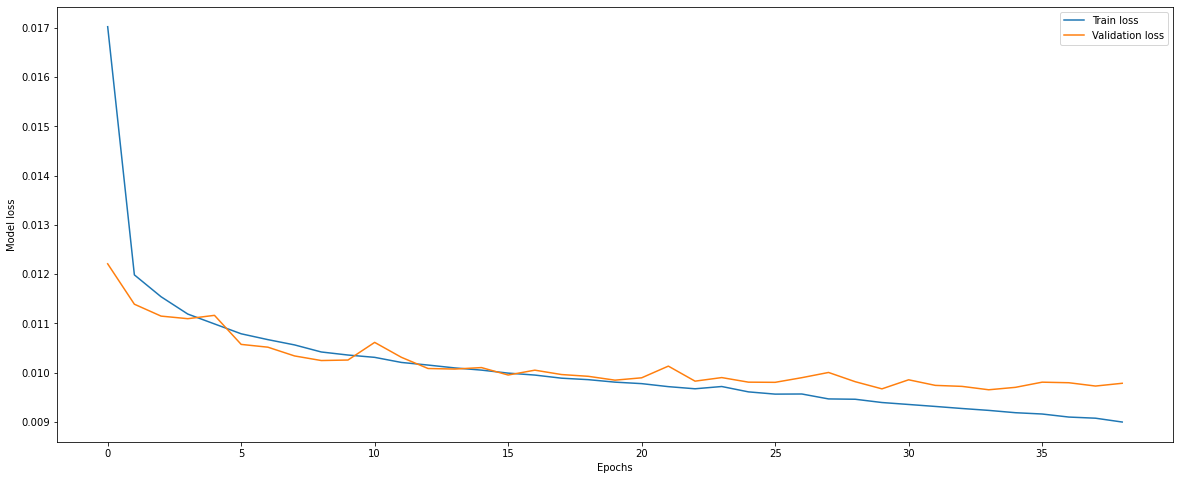

<Figure size 432x288 with 0 Axes>

In [13]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

if os.path.exists(MODEL_PATH):
    print("Loading trained model...")
    lstm_model = tf.keras.models.load_model(MODEL_PATH)
else:
    history = lstm_model.fit(train_x_data, train_y_data, 
                        epochs=100, 
                        batch_size=32, 
                        validation_split=0.25, 
                        verbose=1, 
                        callbacks=[callback]) 

    # plot history
    plt.figure(figsize=(20,8))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.ylabel('Model loss')
    plt.xlabel('Epochs')
    plt.show()
    plt.savefig('/kaggle/working/model_loss.png', dpi=300, bbox_inches='tight')

# Evaluate model

In [14]:
test_x_data, test_y_data  = load_dataset(ids=test_ids, 
                             dataset=df, 
                             train_values=TRAIN_VALUES, 
                             predict_values=PREDICT_VALUES)

test_x_data.shape, test_y_data.shape

for i, value in enumerate(test_x_data):
    value = value[~np.isnan(value).any(axis=1)]
    test_x_data[i] = scaler.transform(value)

for i, value in enumerate(test_y_data):
    value = value[~np.isnan(value).any()]
    test_y_data[i] = scaler.transform(value)

100%|██████████| 5000/5000 [03:08<00:00, 26.47it/s]


In [15]:
lstm_model.evaluate(x=test_x_data, y=test_y_data)

157/157 [==============================] - 3s 19ms/step - loss: 0.0096 - mean_absolute_error: 0.0701


[0.009556655772030354, 0.07014454901218414]

# Results

In [16]:
def expected_vs_predicted(input, expected, predicted):
    expected_values = expected.copy()
    
    index = expected.index.to_pydatetime()

    expected_values.index = index
    
    fitted_series = pd.Series(predicted)
    fitted_series.index=index

    plt.figure(figsize=(20,15))
    plt.subplot(211)

    # plotar gráfico
    plt.plot(input, color='green')
    plt.plot(fitted_series, linestyle='--', color='orange')
    plt.ylim(0, 1)
    plt.legend(['real', 'previsto'], loc='upper left')

    rmse = np.sqrt(mean_squared_error(expected_values, predicted))

    return rmse

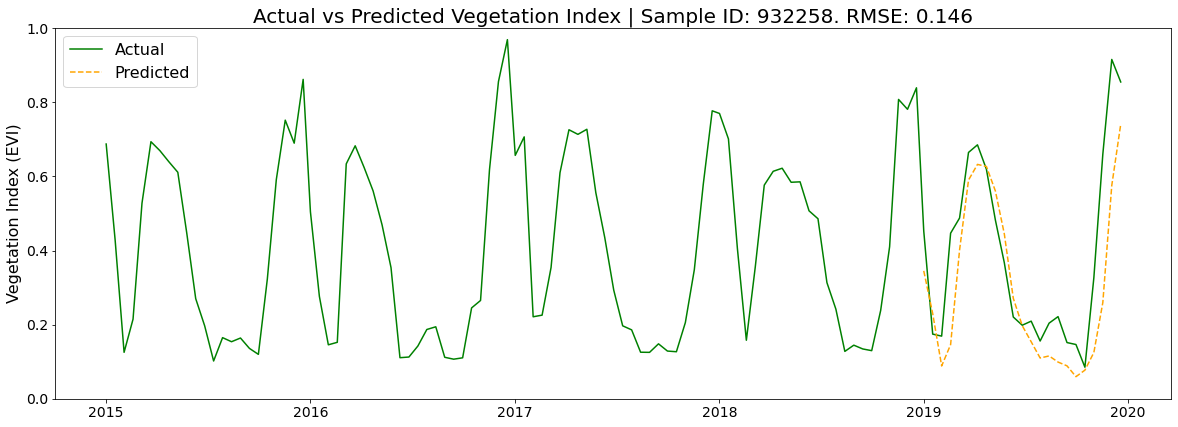

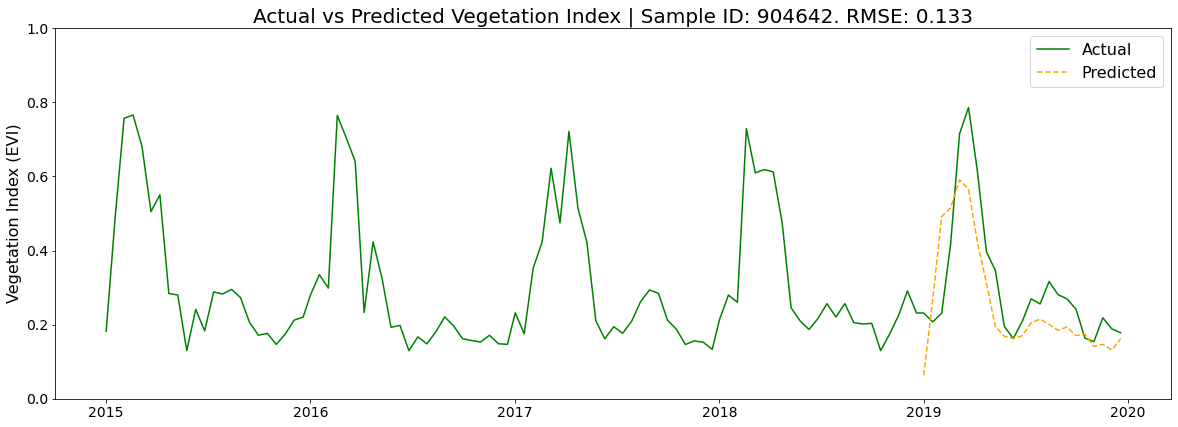

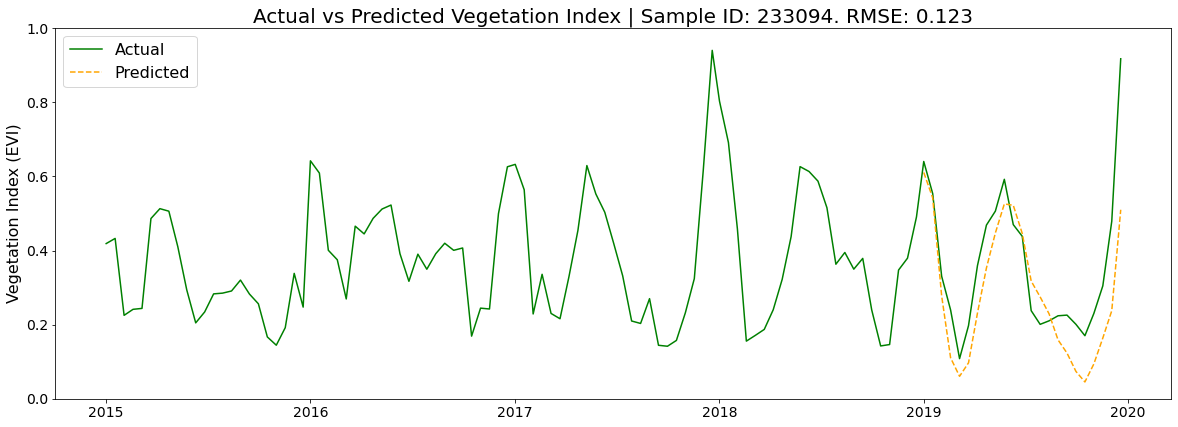

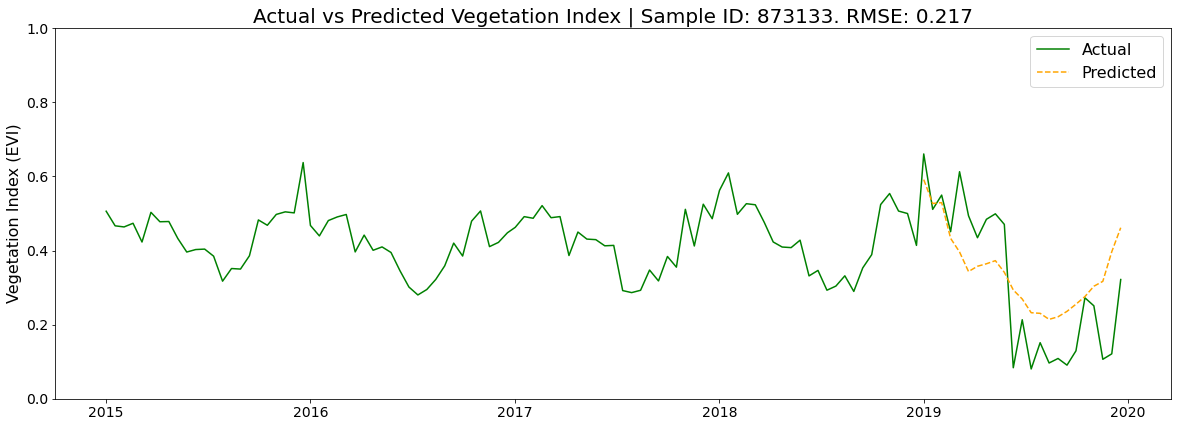

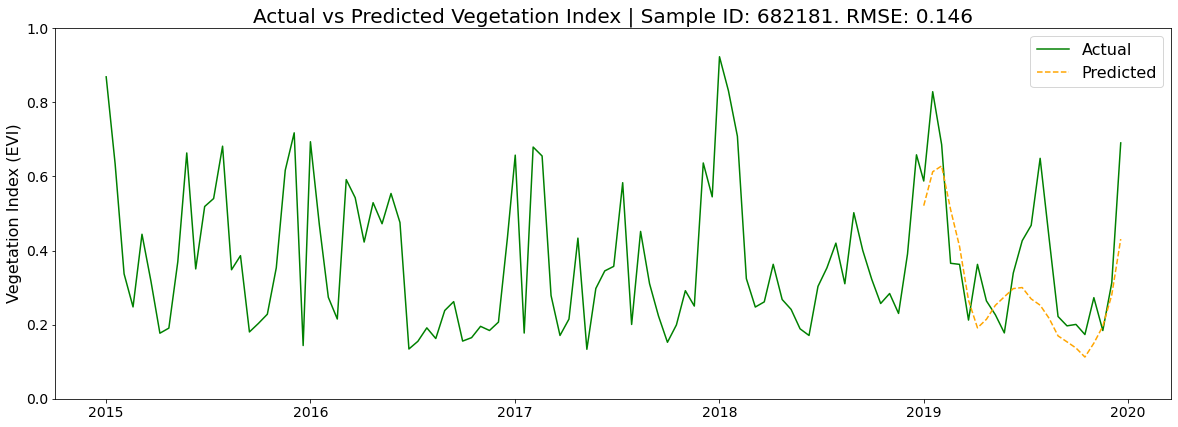

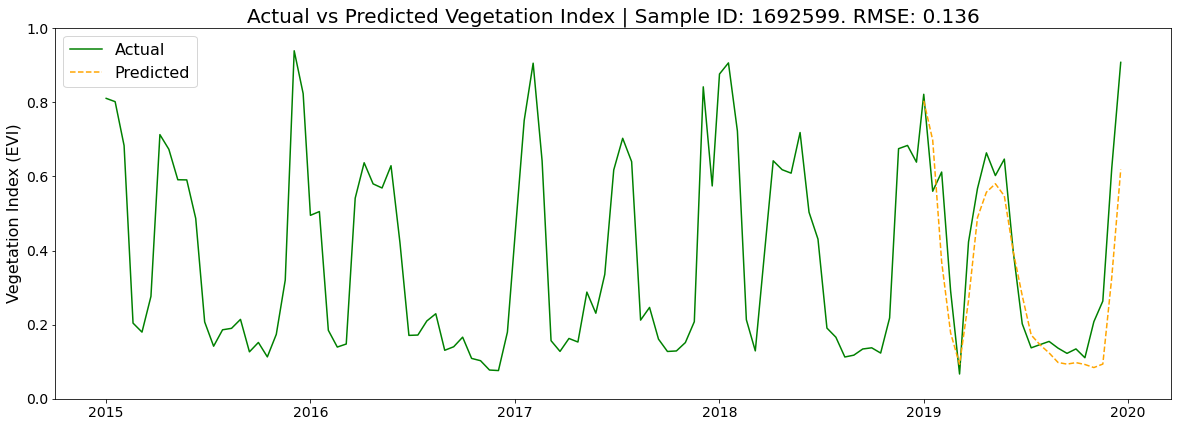

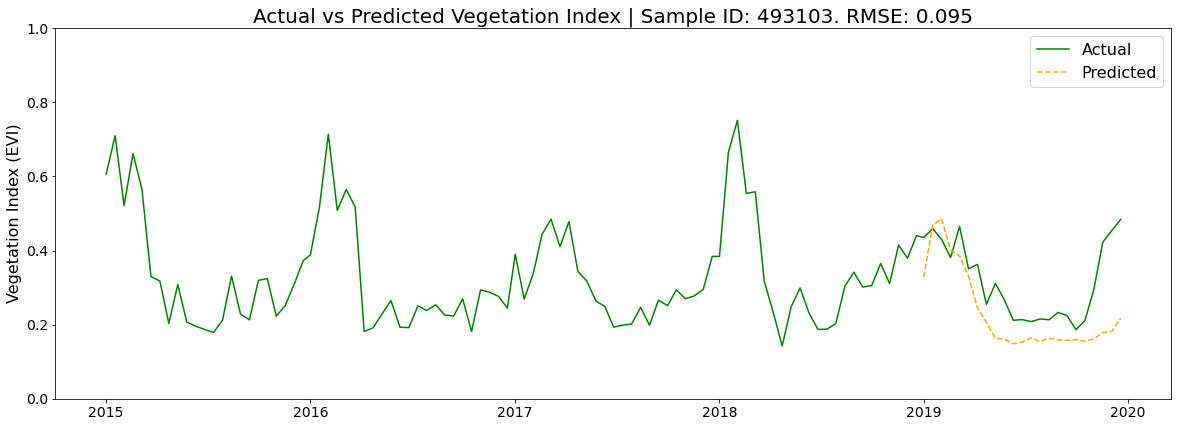

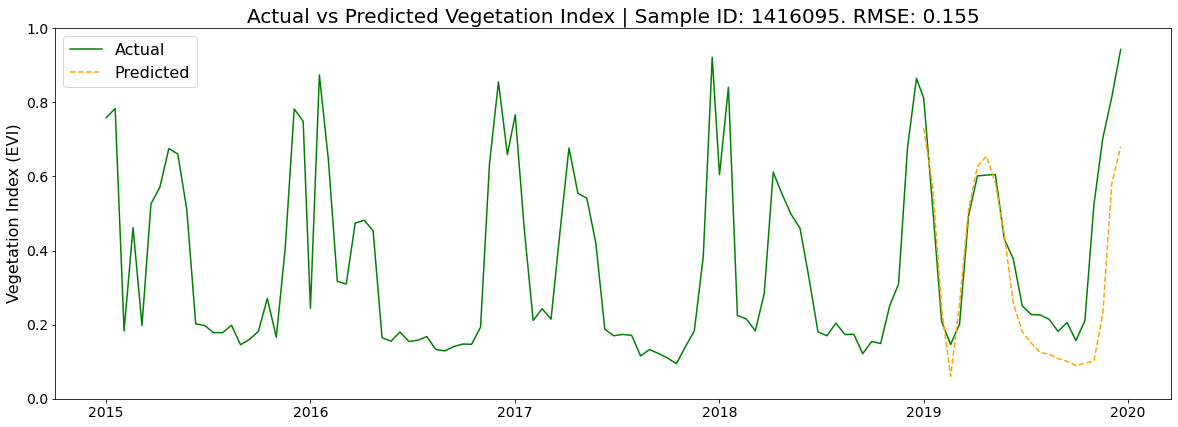

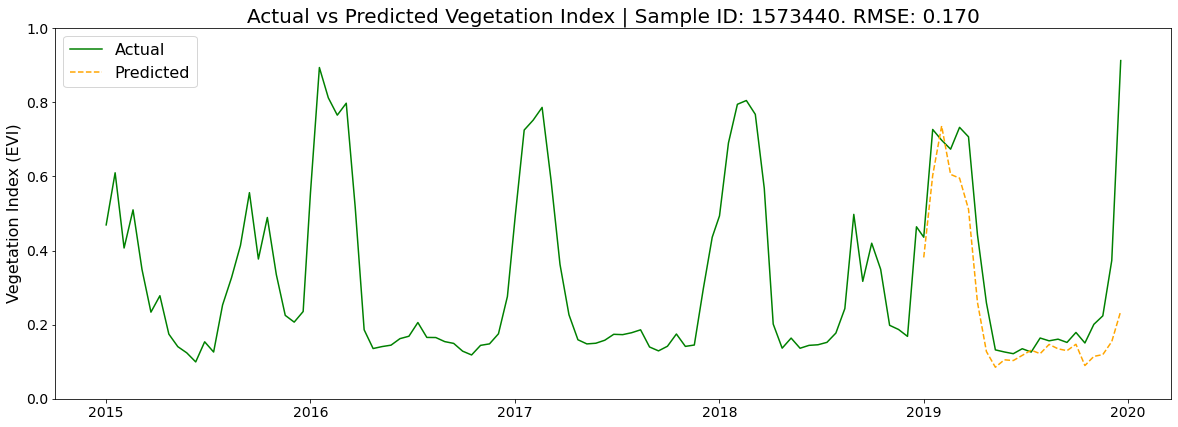

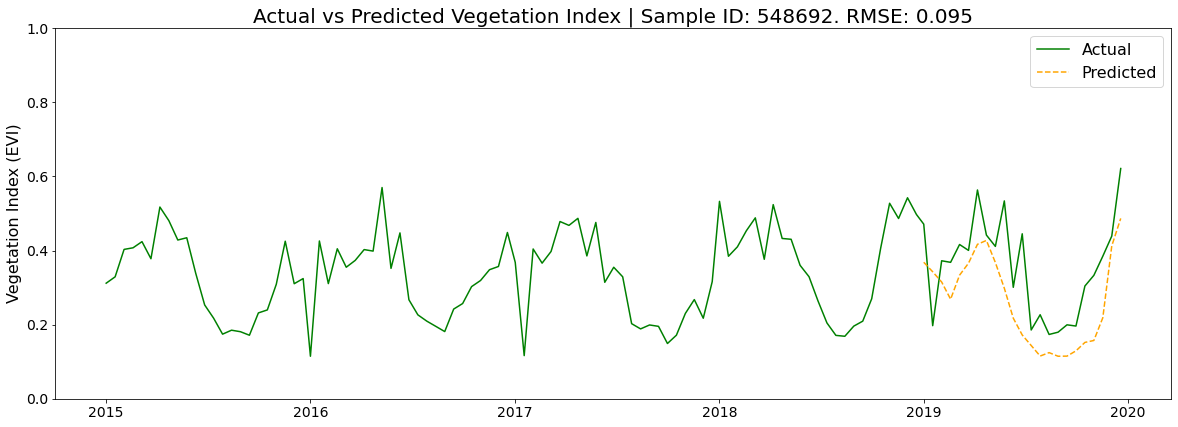

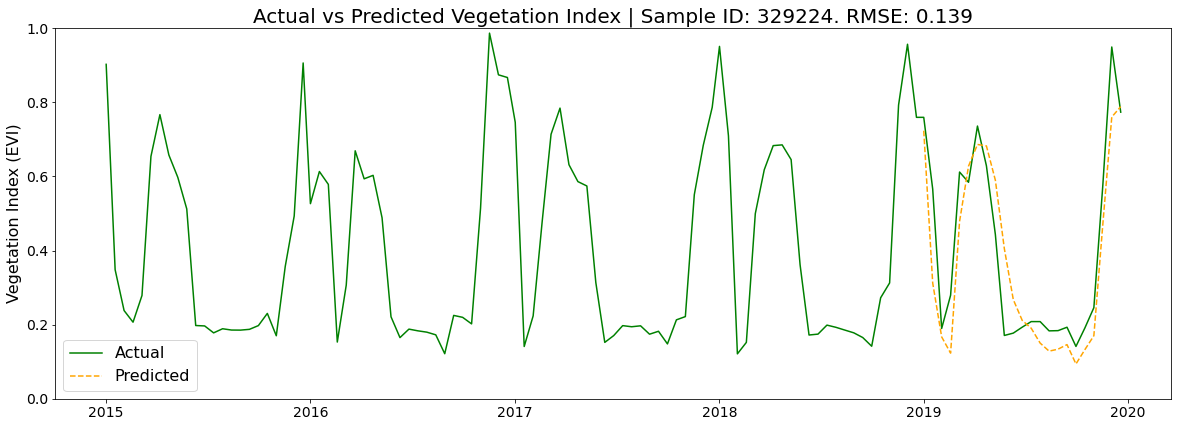

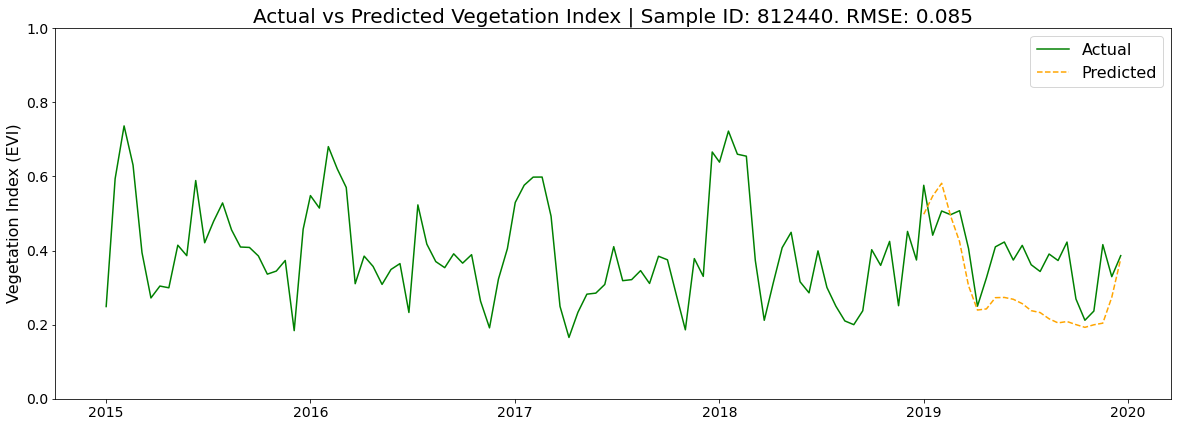

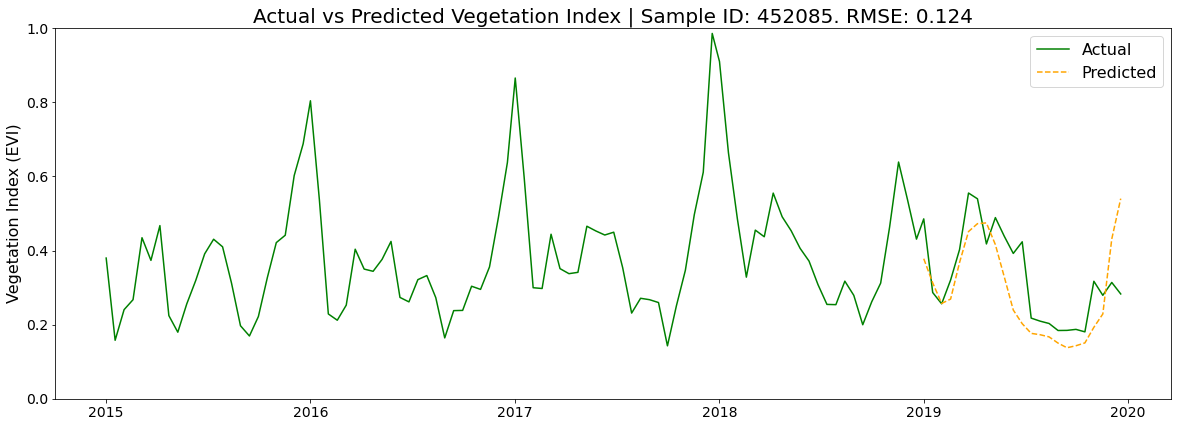

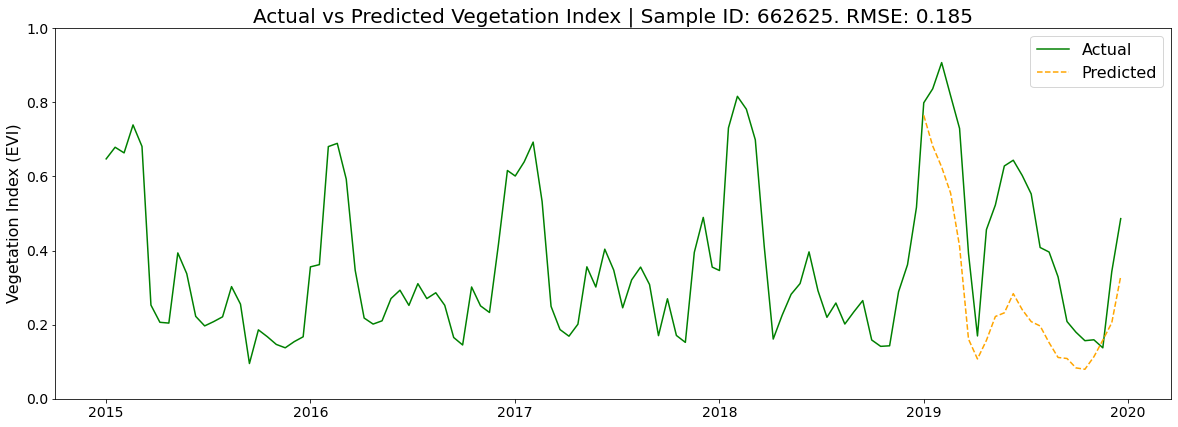

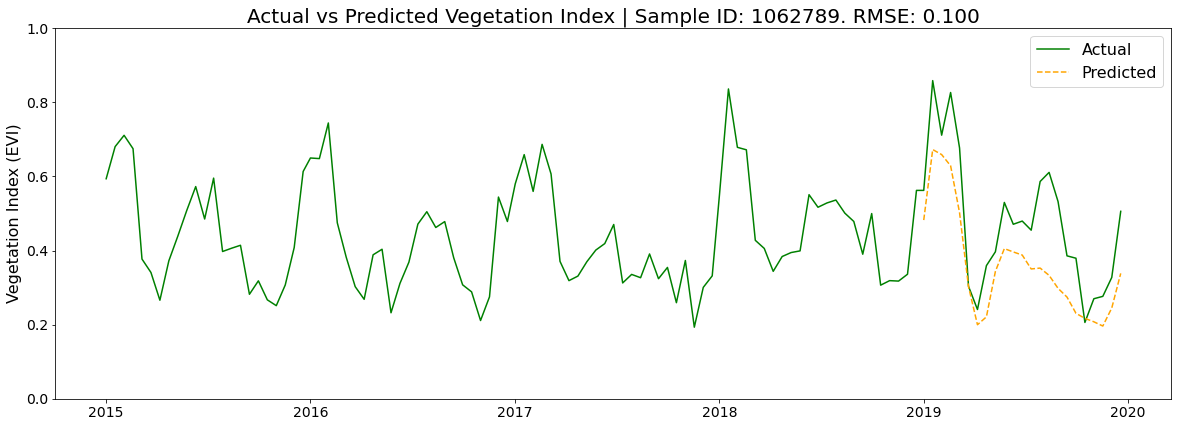

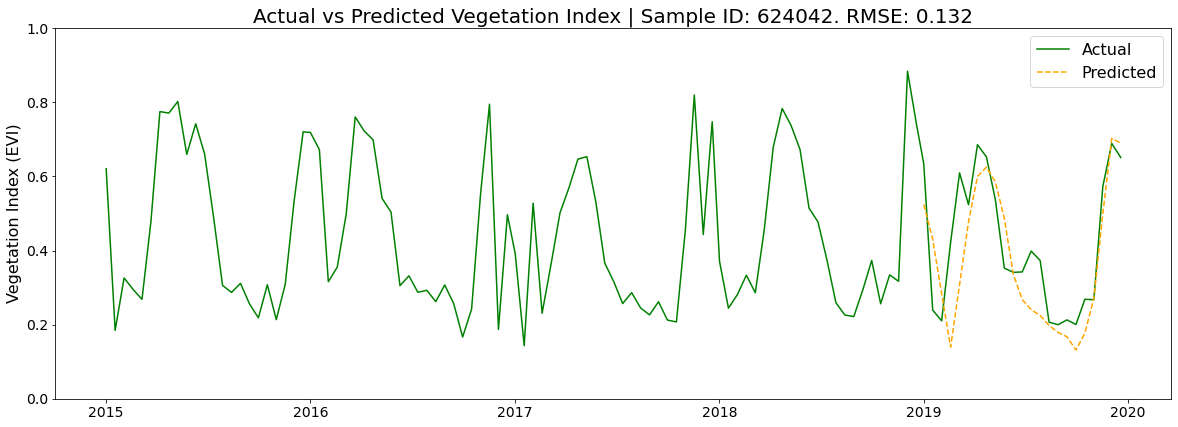

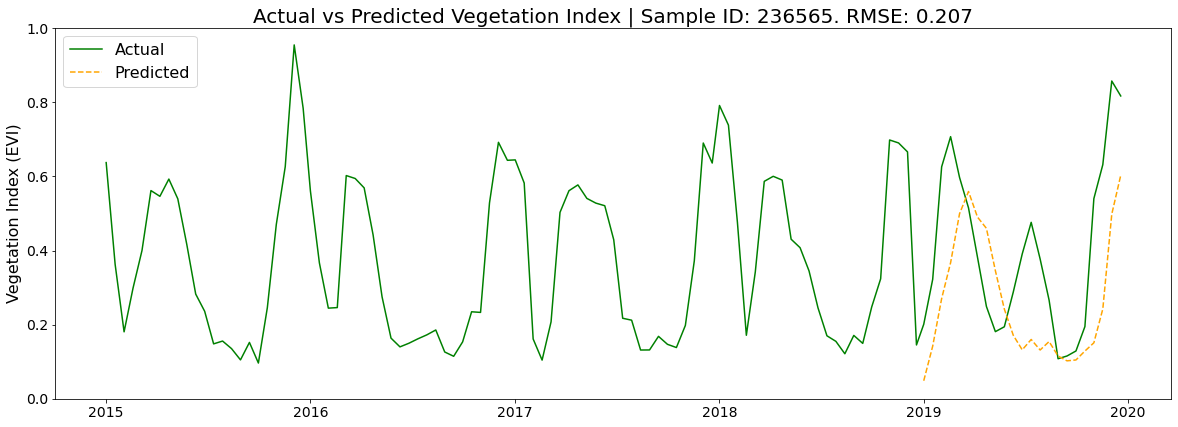

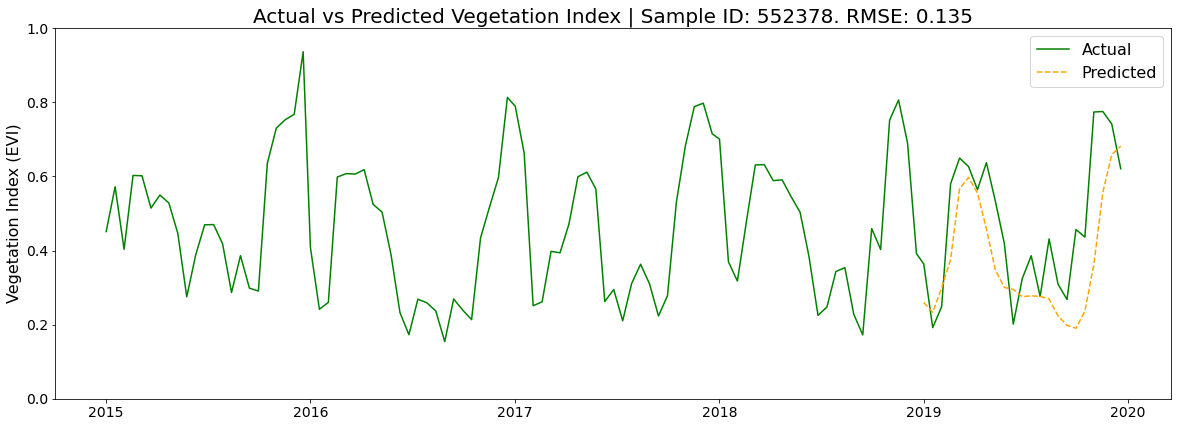

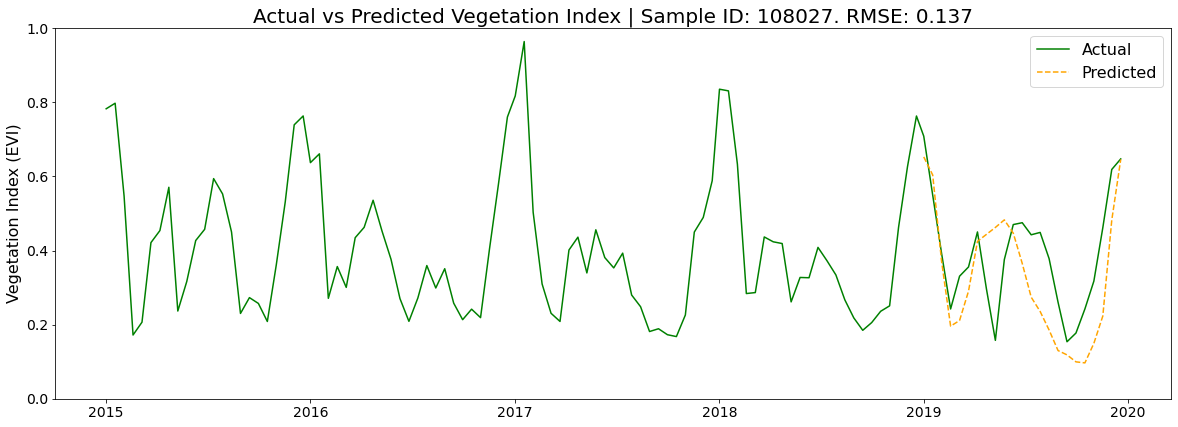

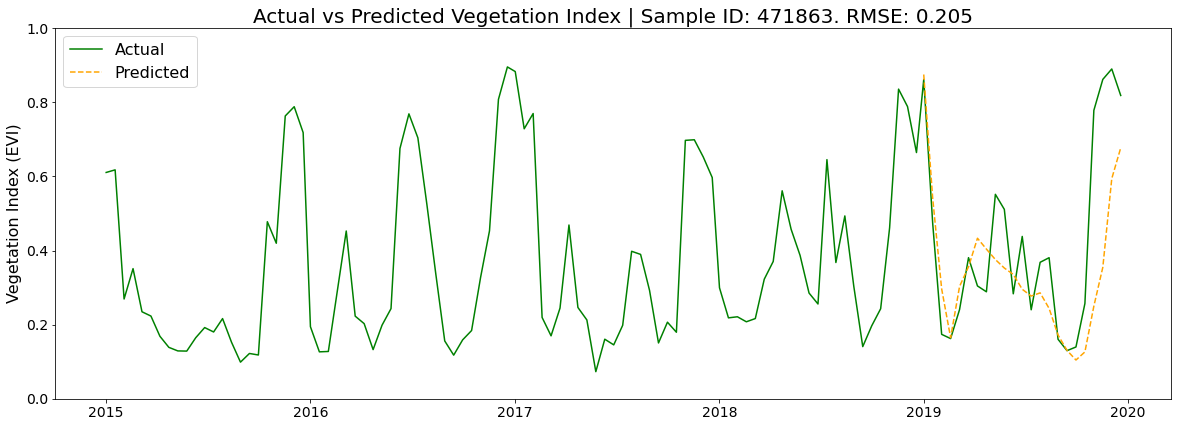

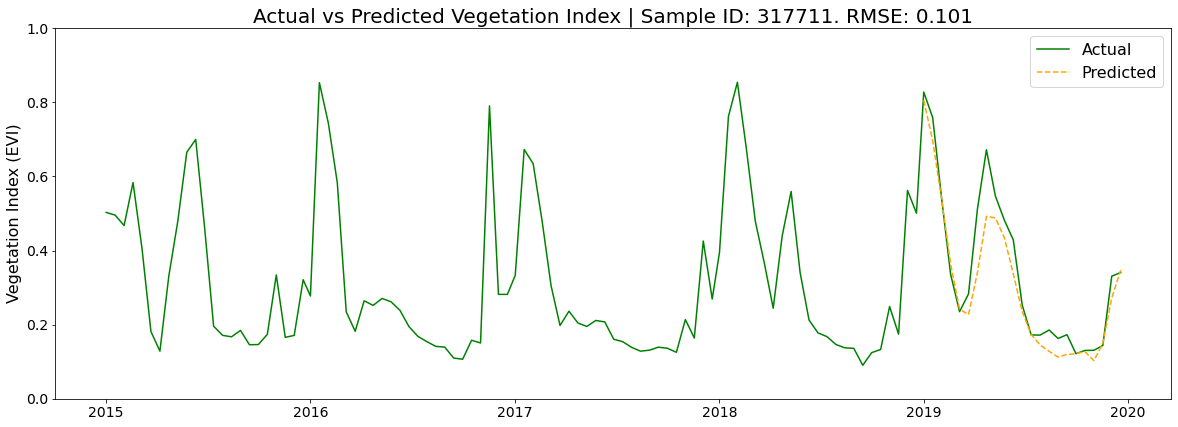

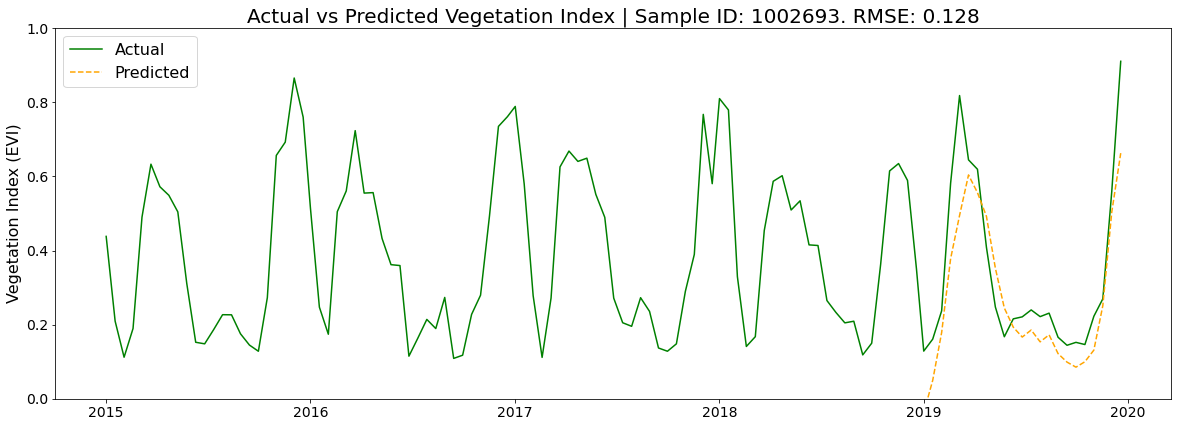

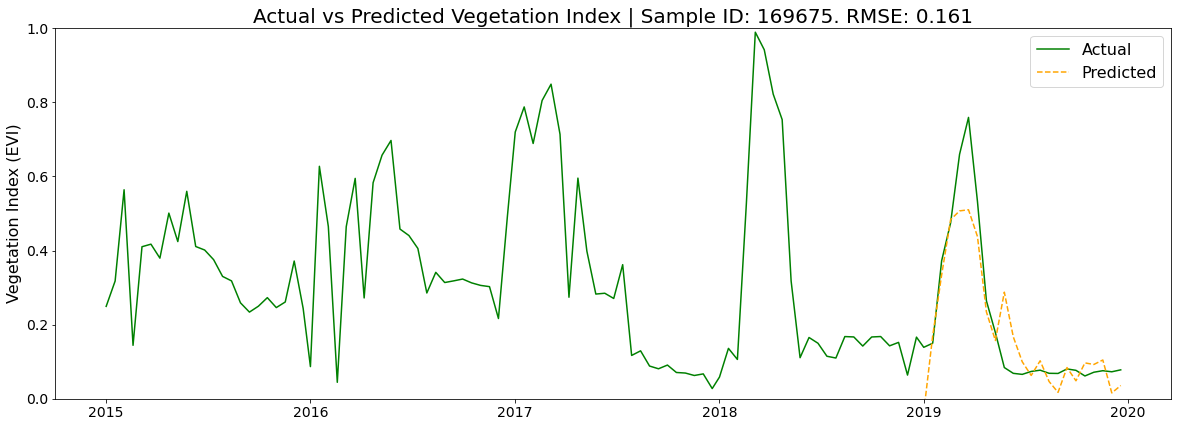

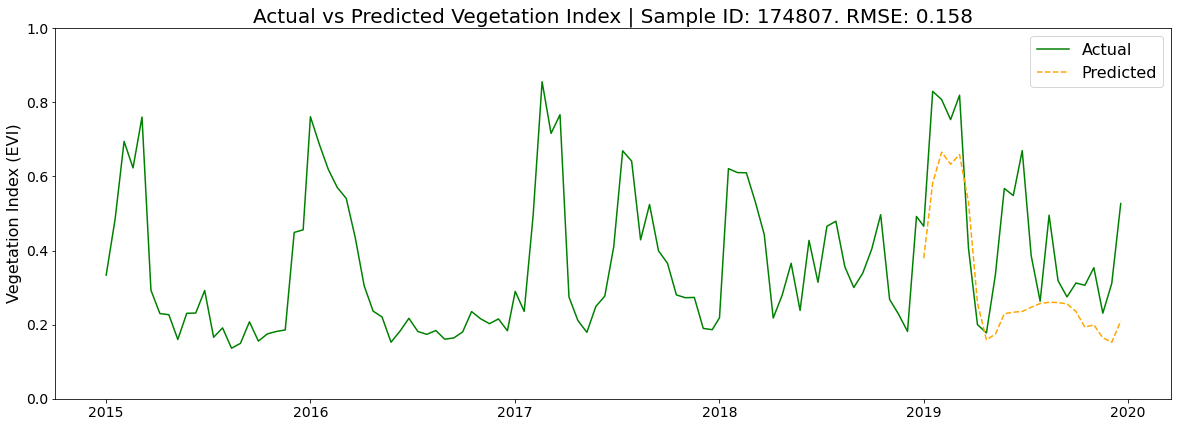

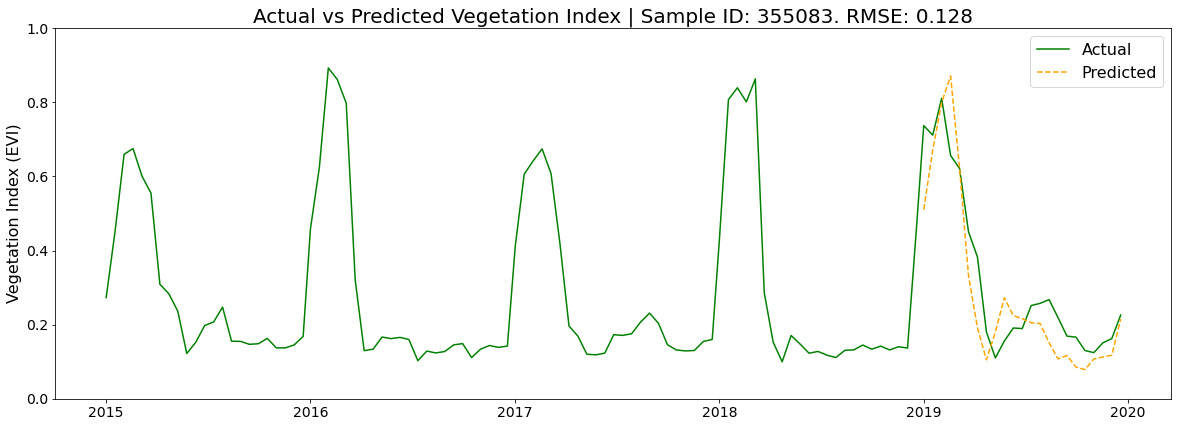

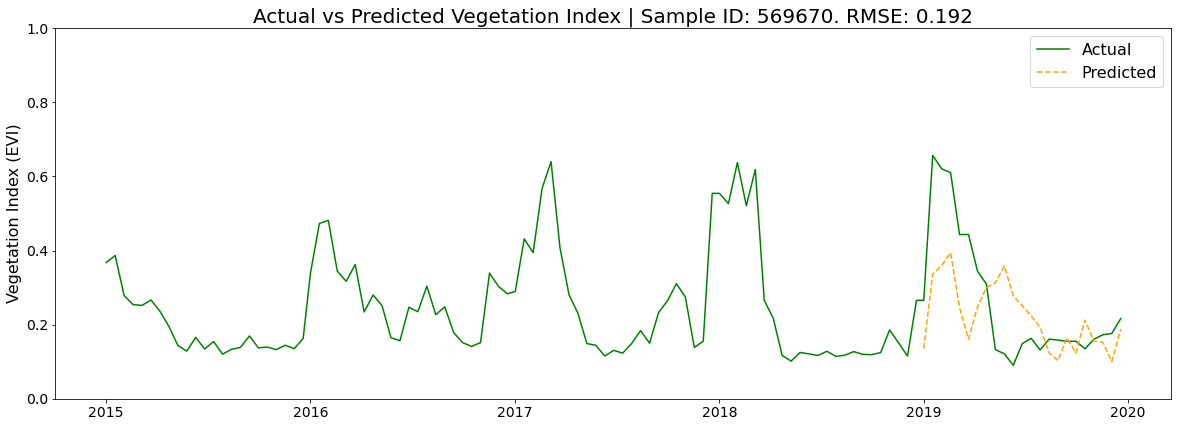

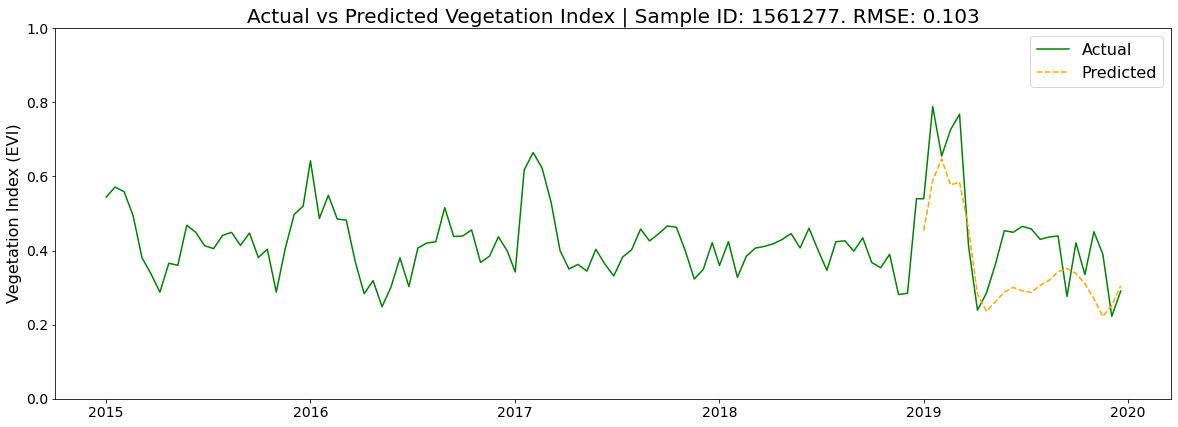

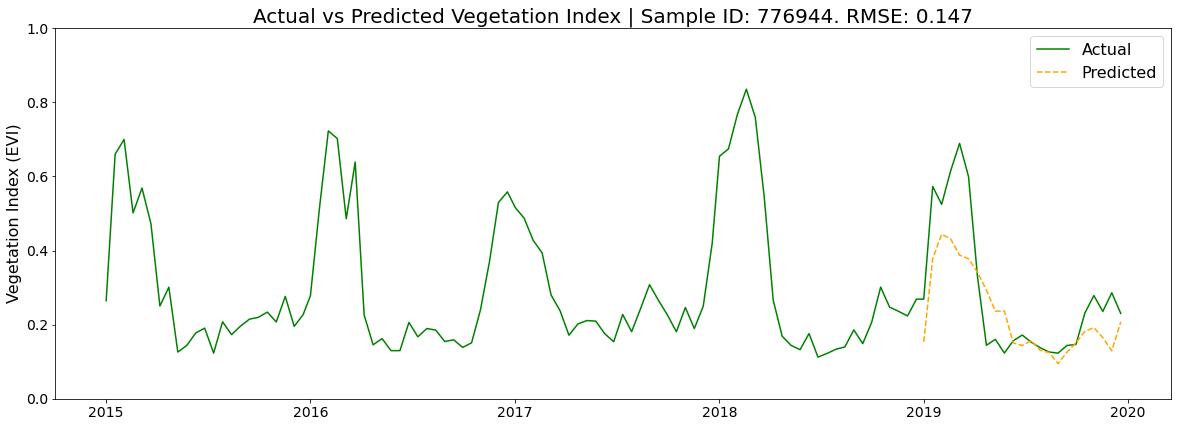

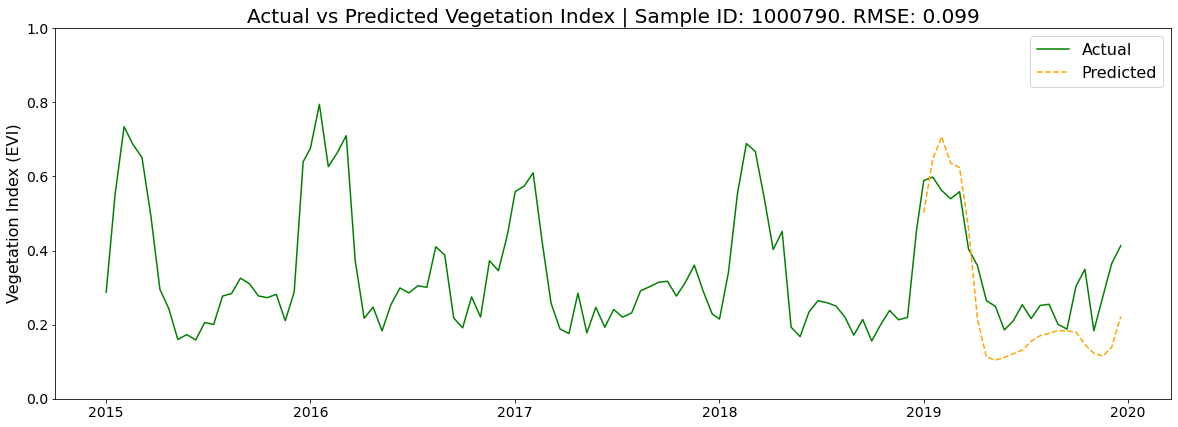

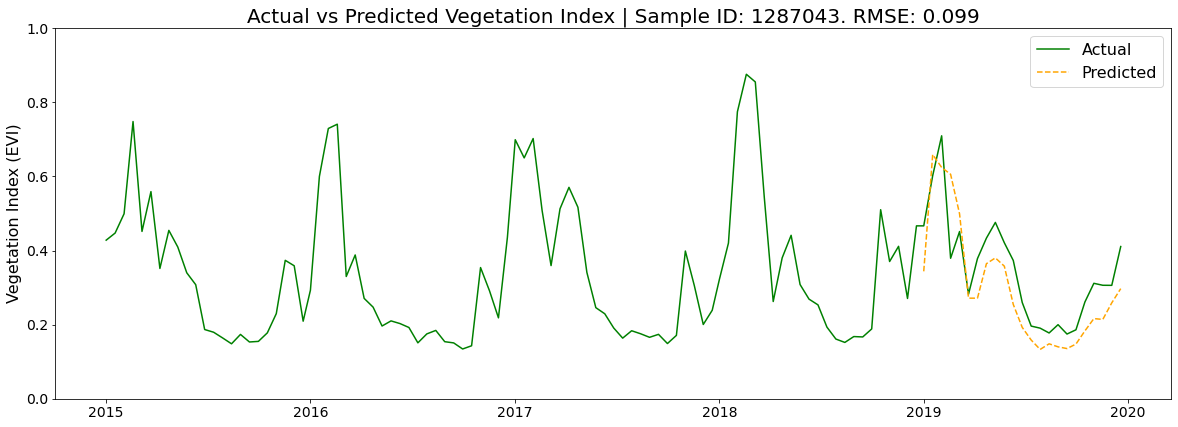

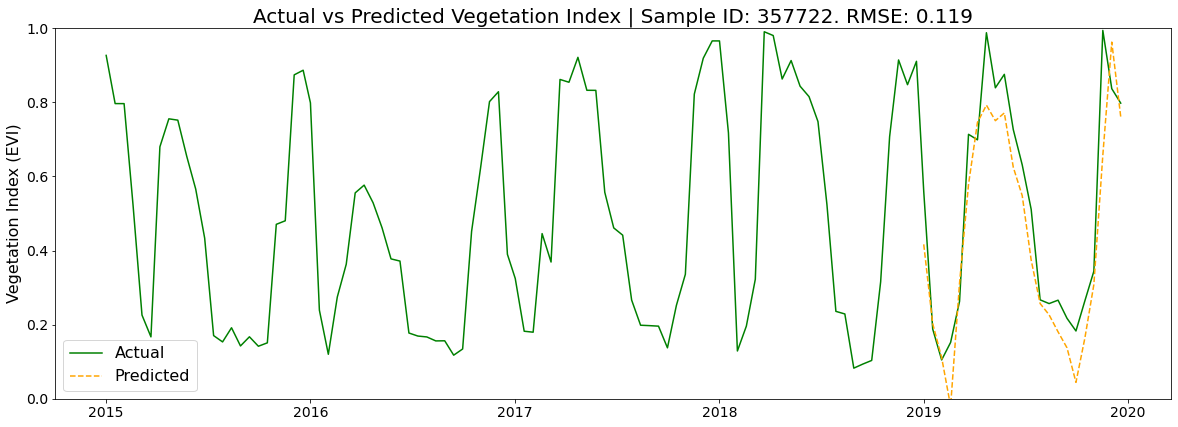

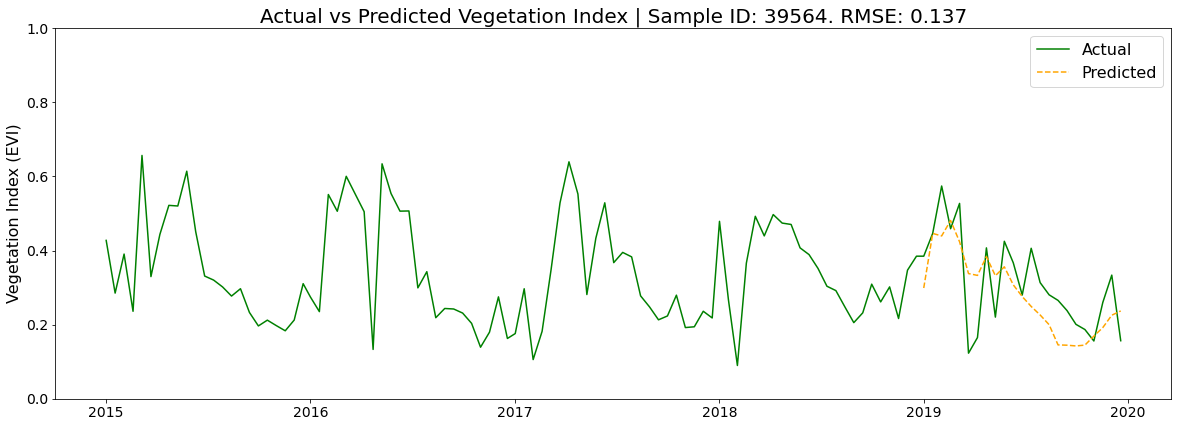

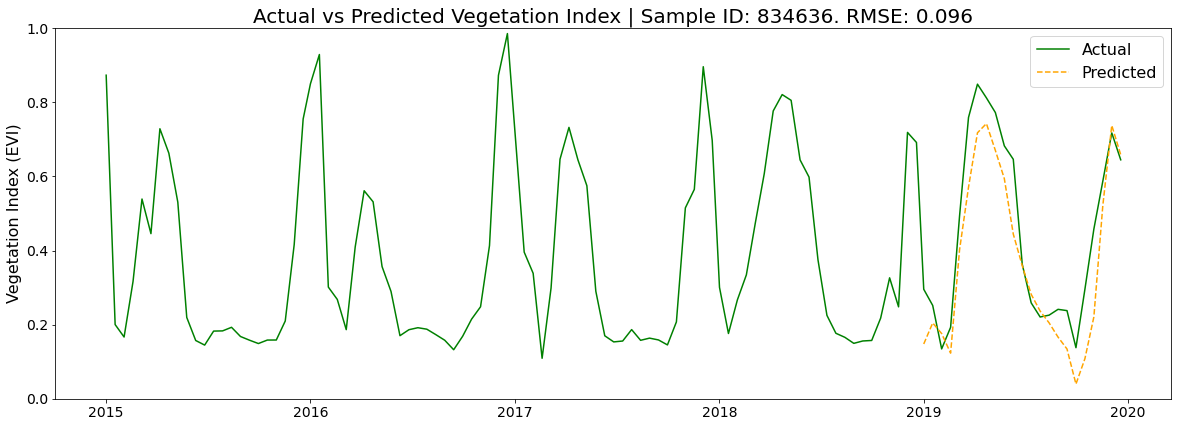

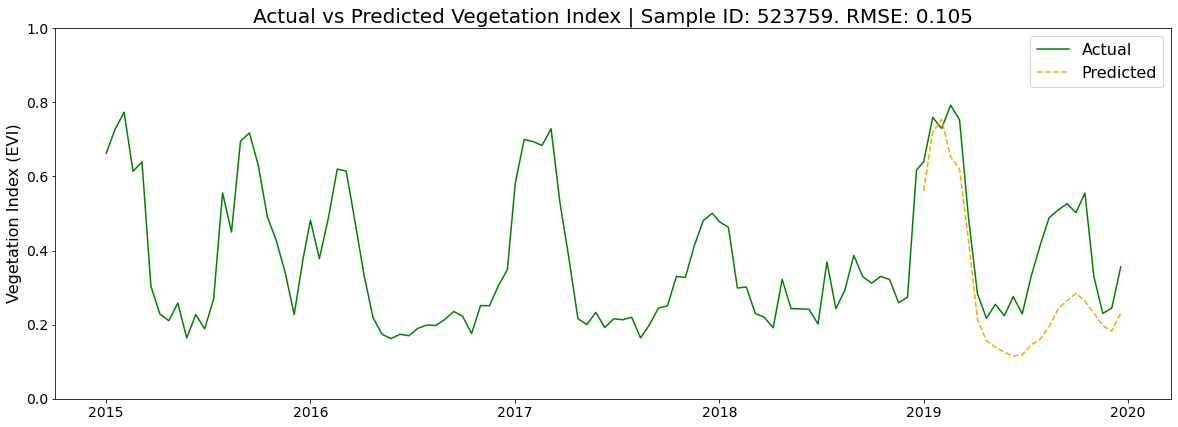

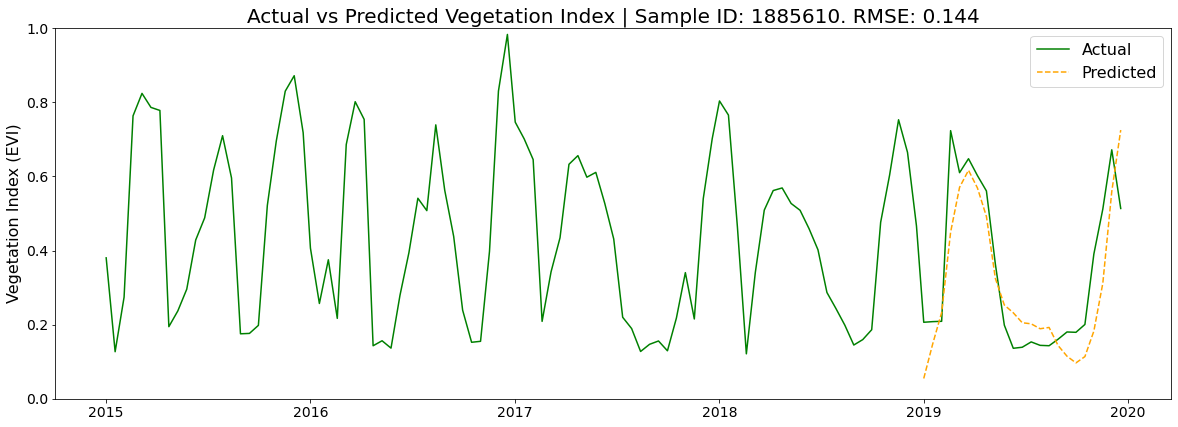

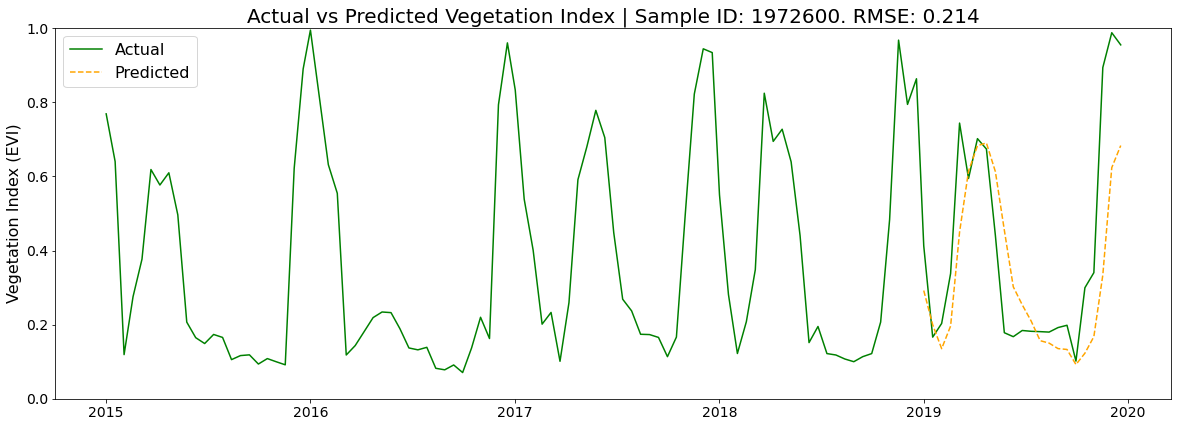

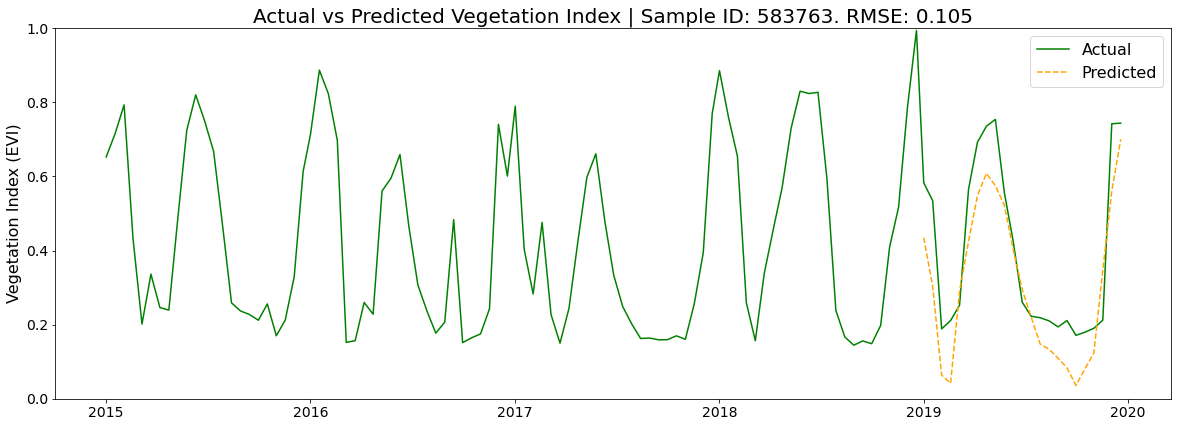

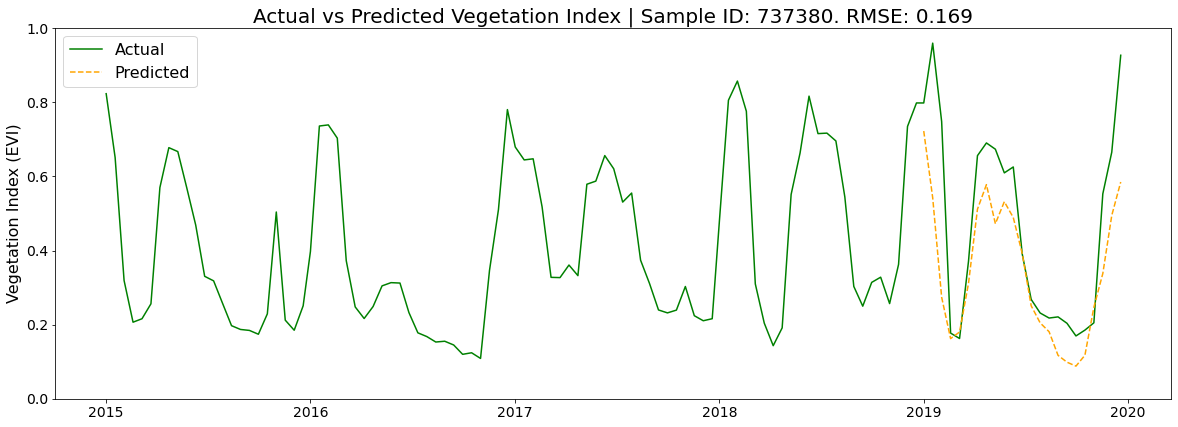

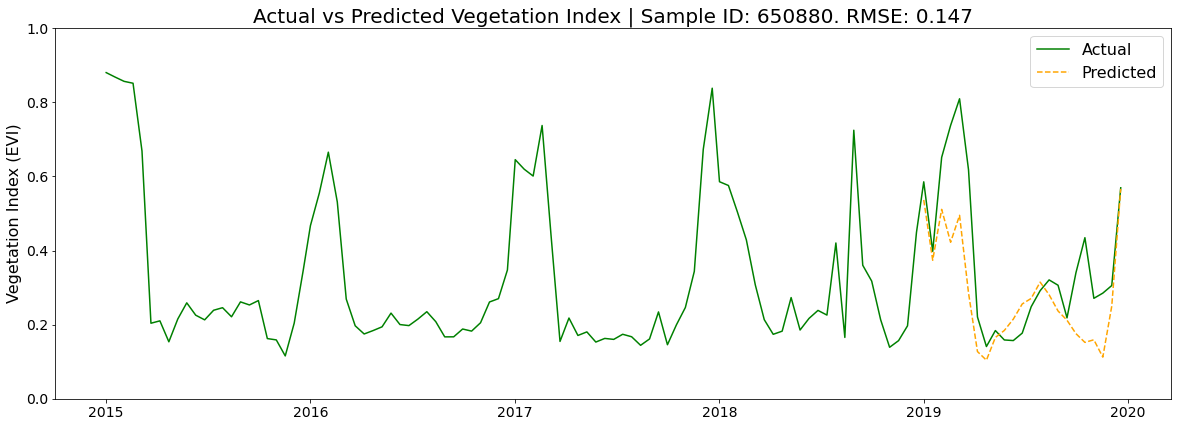

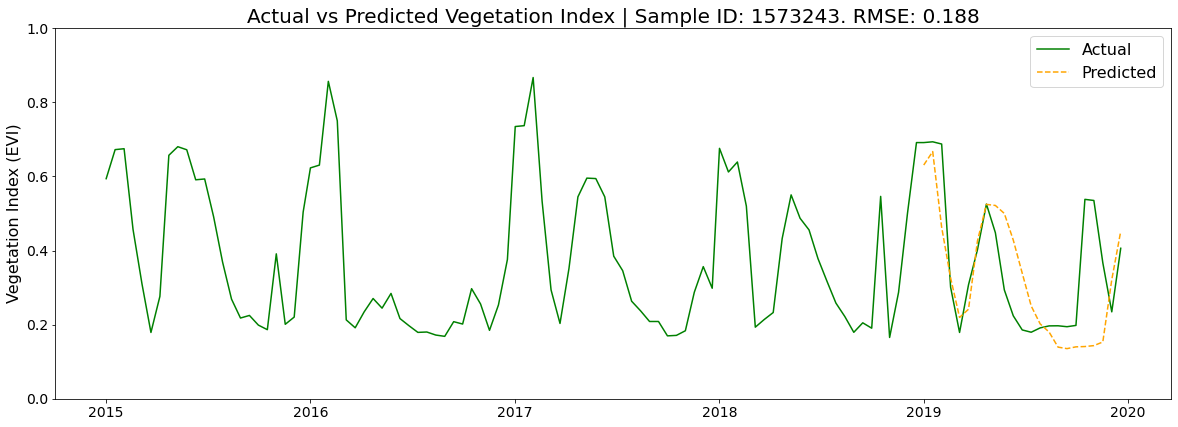

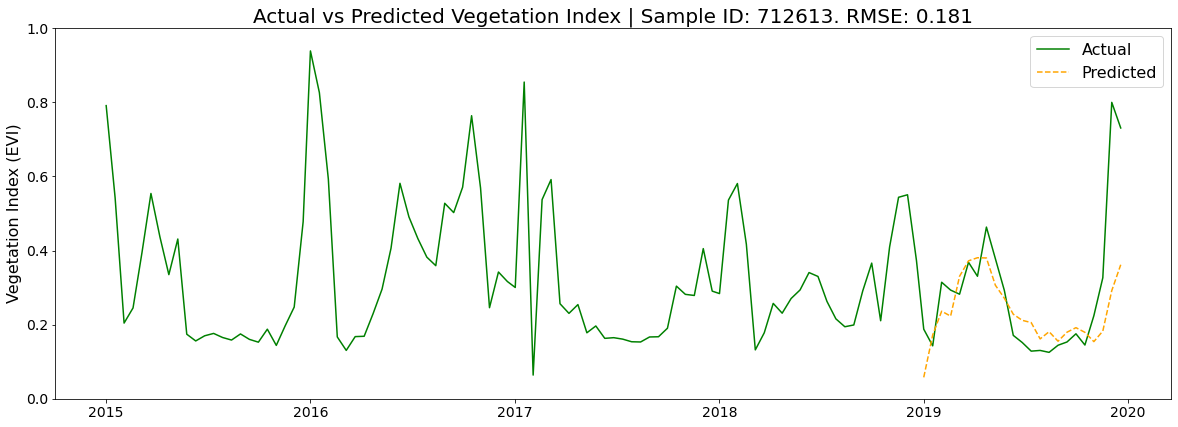

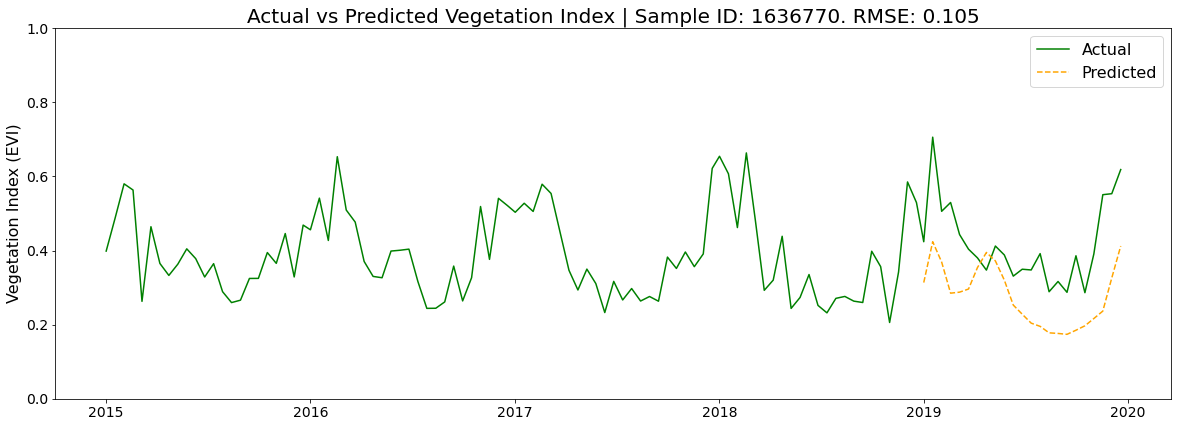

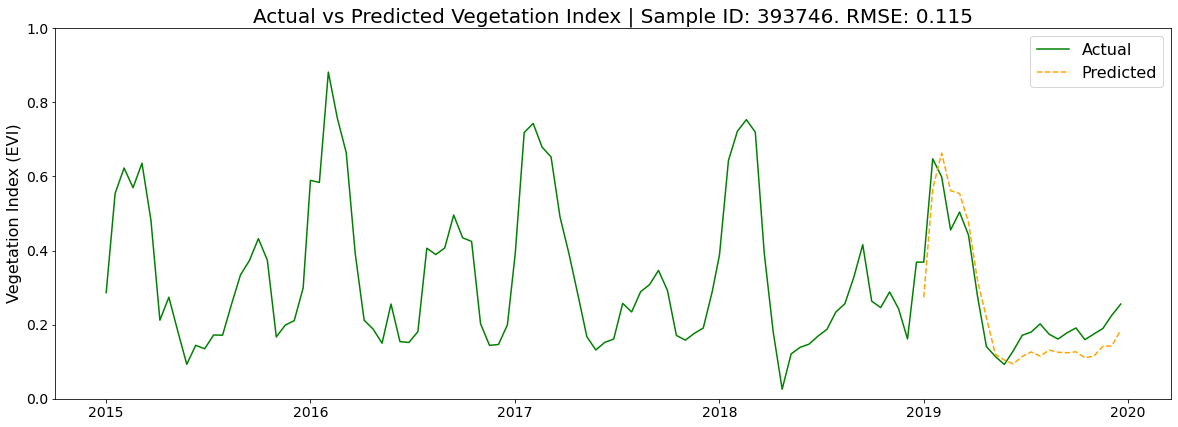

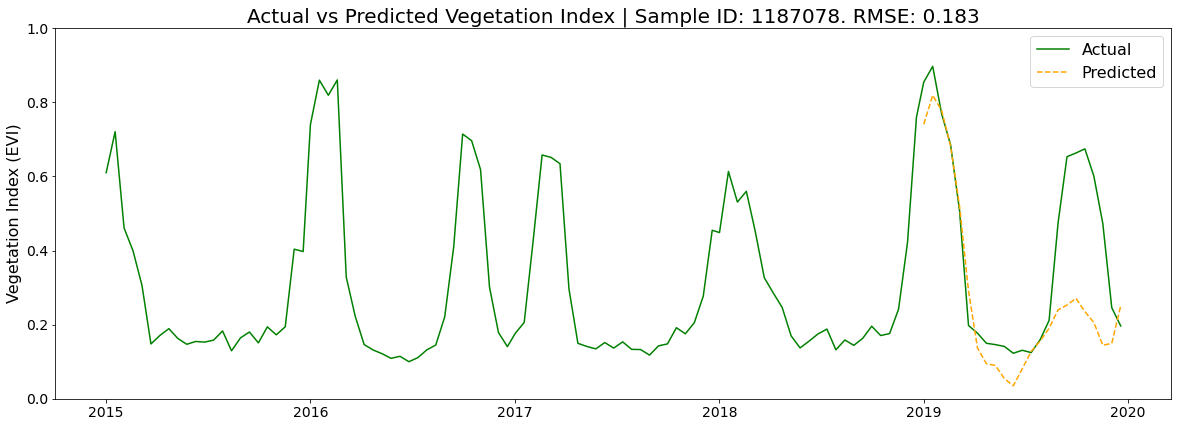

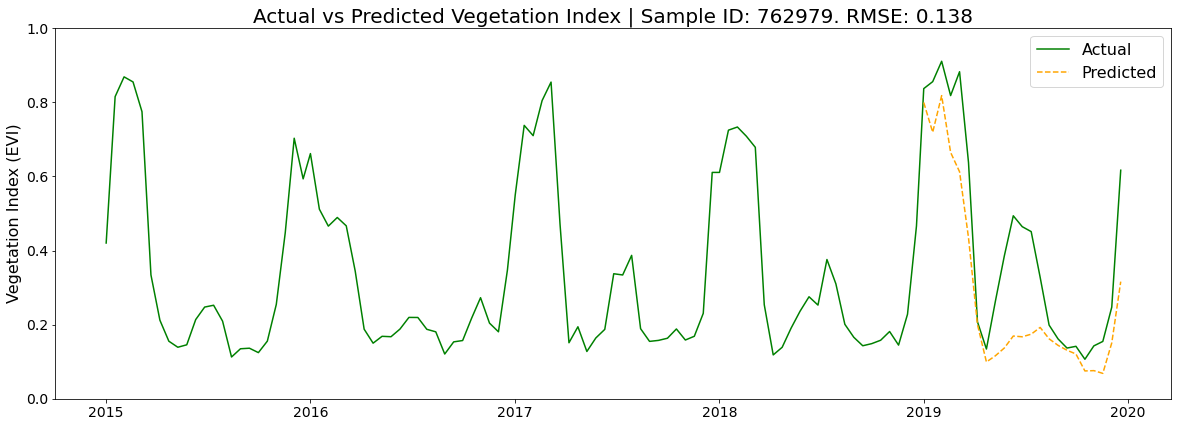

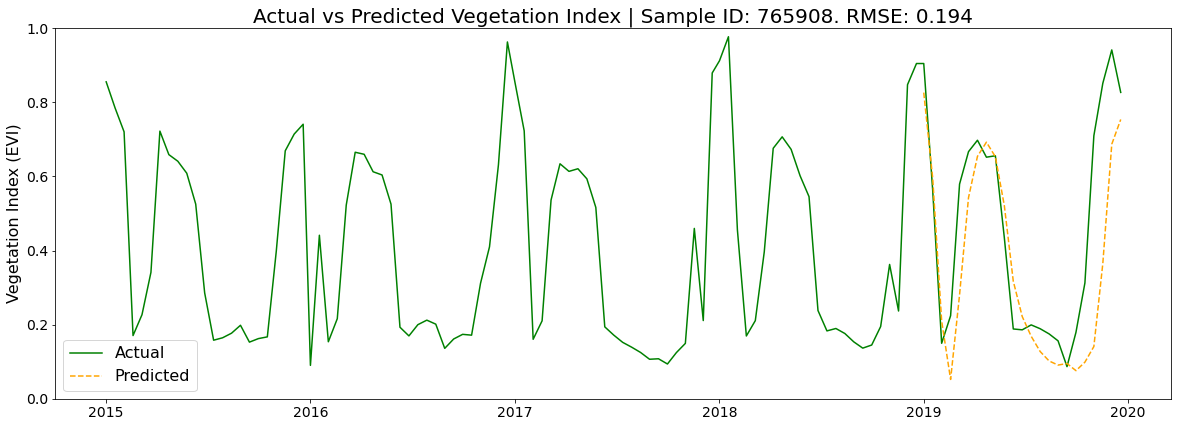

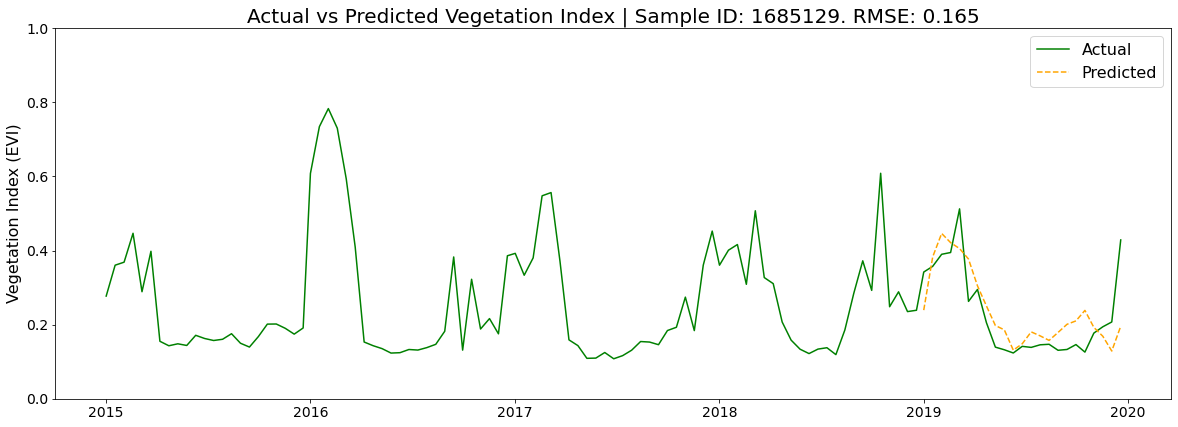

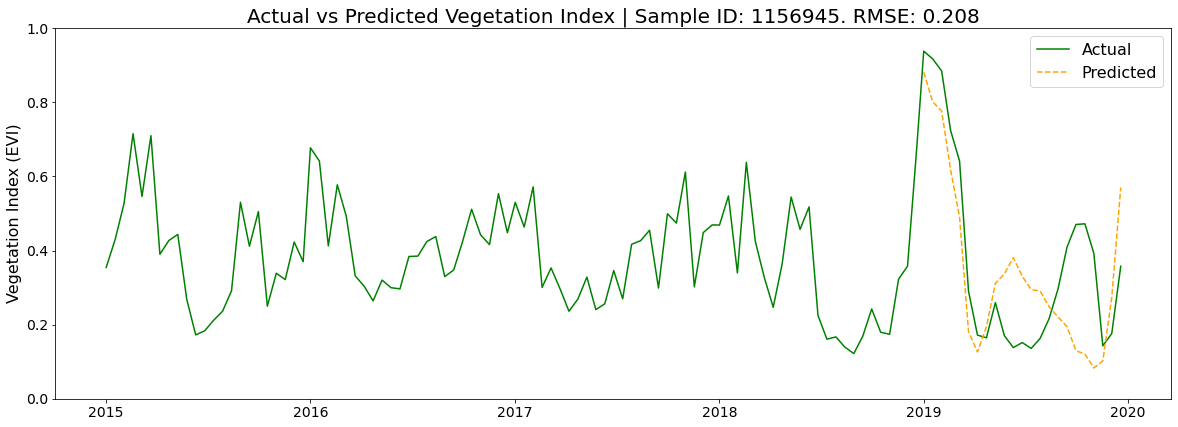

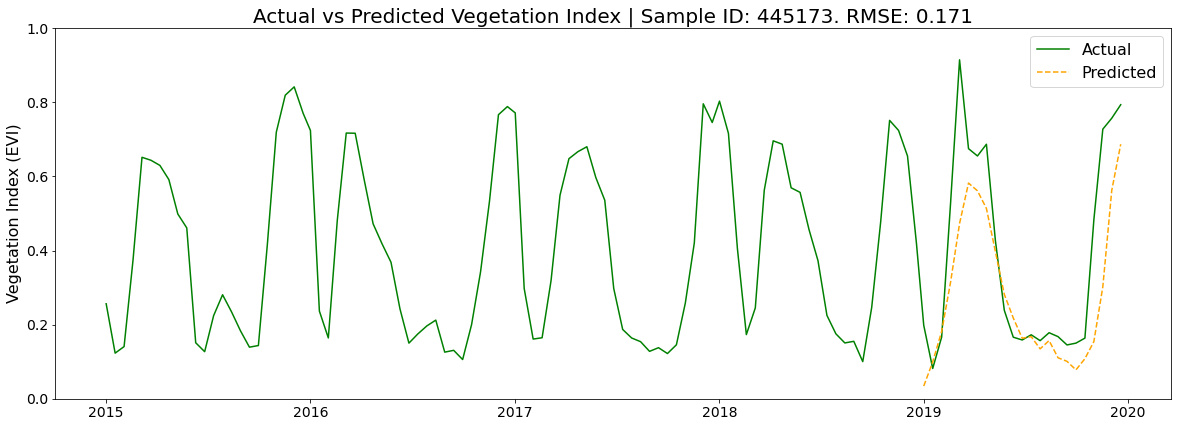

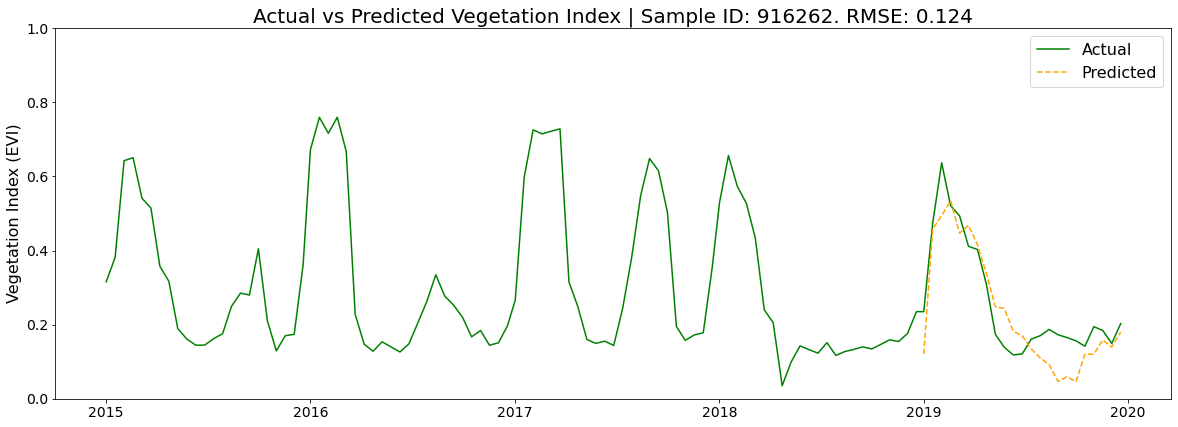

In [18]:
for id in test_ids[:50]:
    data = df[(df[FIELD_ID] == id)]
    index = pd.DatetimeIndex(pd.to_datetime(data[FIELD_TIMESTAMP],  unit='ms'))
    data.index = index

    input = data.loc[:PREDICT_START_DATE][TRAIN_FEATURES].dropna()
    input = tf.keras.preprocessing.sequence.pad_sequences([input], maxlen=TRAIN_VALUES, dtype='float32')[0]

    expected = data.loc[PREDICT_START_DATE:PREDICT_END_DATE][PREDICT_FEATURE]
    expected = expected.dropna()

    if len(expected) != PREDICT_VALUES:
        continue
        
    predicted = lstm_model.predict(np.array([input]))[0]

    # inverse transform
    reescaled_expected = scaler.inverse_transform(expected.values.reshape(expected.values.shape[0], 1)).flatten()
    reescaled_predicted = scaler.inverse_transform(predicted.reshape(predicted.shape[0], 1)).flatten()

    reescaled_expected = pd.Series(reescaled_expected, index=expected.index)

    rmse = expected_vs_predicted(data[TRAIN_FEATURES].loc['2015-01-01':].dropna(), reescaled_expected, reescaled_predicted)
    plt.title("Actual vs Predicted Vegetation Index | Sample ID: %s. RMSE: %.3f" % (str(id), rmse, ), fontsize=20)
    plt.ylabel('Vegetation Index (EVI)', fontsize=16)
    plt.xlabel(None)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(['Actual', 'Predicted'], fontsize=16)
    plt.show()